In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import cmath
import scipy as sp
%matplotlib inline
from scipy import integrate

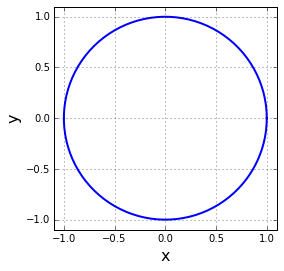

In [5]:
# defines the cylinder
R = 1.0                                                     # radius
theta = np.linspace(0, 2*np.pi, 100)                           # angles in radians
x_cylinder, y_cylinder = R*np.cos(theta), R*np.sin(theta)   # coordinates of the cylinder

# plots the cylinder
%matplotlib inline

size = 4
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1);

In [6]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

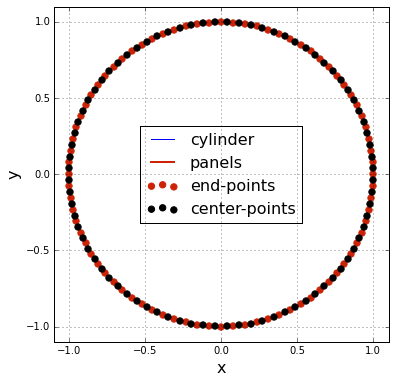

In [39]:
N_panels = 80                    # number of panels desired

# defining the end-points of the panels
x_ends = R*np.cos(np.linspace(0, 2*np.pi, N_panels+1))
y_ends = R*np.sin(np.linspace(0, 2*np.pi, N_panels+1))

# defining the panels
panels = np.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plotting the panels
size = 6
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=1)
plt.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
plt.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
plt.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', s=40, zorder=3)
plt.legend(['cylinder', 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1);

In [13]:
class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf=1.0, alpha=0.0):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        u_inf -- Farfield speed (default 1.0).
        alpha -- Angle of attack in degrees (default 0.0).
        """
        self.u_inf = u_inf
        self.alpha = alpha*np.pi/180          # degrees --> radians

In [14]:
# defines and creates the object freestream
u_inf = 1.0                                # freestream spee
alpha = 0.0                                # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)      # instantiation of the object freestream

In [15]:
def integral(x, y, panel, dxdz, dydz):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    dxdz -- derivative of x in the z-direction.
    dydz -- derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    def func(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdz
                  +(y - (panel.ya + np.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - np.sin(panel.beta)*s))**2
                   +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return sp.integrate.quad(lambda s:func(s), 0., panel.length)[0]

In [16]:
def build_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/np.pi*integral(p_i.xc, p_i.yc, p_j, np.cos(p_i.beta), np.sin(p_i.beta))
    
    return A

def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    
    Returns
    -------
    b -- 1D array ((N+1)x1, N is the number of panels).
    """
    b = np.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    
    return b

In [17]:
A = build_matrix(panels)                        # computes the singularity matrix
b = build_rhs(panels, freestream)               # computes the freestream RHS

In [19]:
# solves the linear system
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [20]:
def get_tangential_velocity(panels, freestream):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/np.pi*integral(p_i.xc, p_i.yc, p_j, -np.sin(p_i.beta), np.cos(p_i.beta))
    
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta for panel in panels])
    
    sigma = np.array([panel.sigma for panel in panels])
    
    vt = np.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [21]:
# computes the tangential velocity at the center-point of each panel
get_tangential_velocity(panels, freestream)

In [22]:
def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [23]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

In [28]:
def get_velocity_field(panels, freestream, X, Y):
    """Returns the velocity field.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    X, Y -- mesh grid.
    """
    Nx, Ny = X.shape
    u, v = np.empty((Nx, Ny), dtype=float), np.empty((Nx, Ny), dtype=float)
    
    for i in range(Nx):
        for j in range(Ny):
            u[i,j] = freestream.u_inf*np.cos(freestream.alpha)\
                     + 0.5/np.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 1, 0) for p in panels])
            v[i,j] = freestream.u_inf*np.sin(freestream.alpha)\
                     + 0.5/np.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 0, 1) for p in panels])
    
    return u, v

In [34]:
# defines a mesh grid
Nx, Ny = 30, 30                  # number of points in the x and y directions
val_x, val_y = 1.0, 1.0
x_min, x_max = min( panel.xa for panel in panels ), max( panel.xa for panel in panels )
y_min, y_max = min( panel.ya for panel in panels ), max( panel.ya for panel in panels )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = y_min-val_y*(y_max-y_min), y_max+val_y*(y_max-y_min)

X, Y = np.meshgrid(np.linspace(x_start, x_end, Nx), np.linspace(y_start, y_end, Ny))

# computes the velicity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

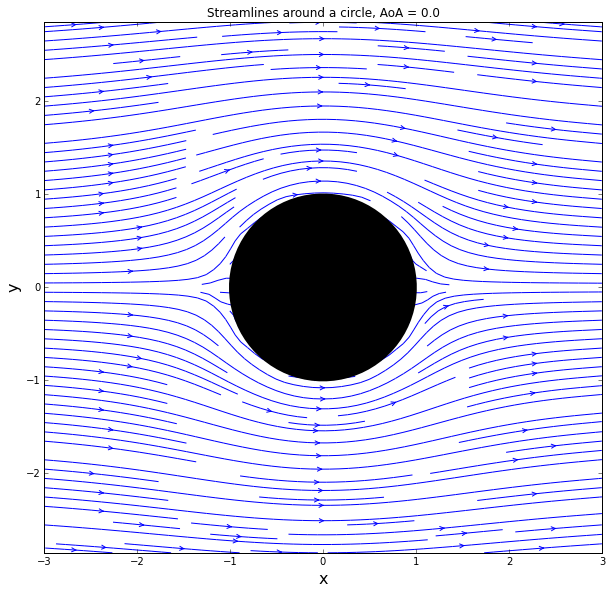

In [42]:
# plots the velocity field
size=10
plt.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
plt.fill([panel.xc for panel in panels], 
         [panel.yc for panel in panels], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.title('Streamlines around a circle, AoA = %.1f' % alpha);

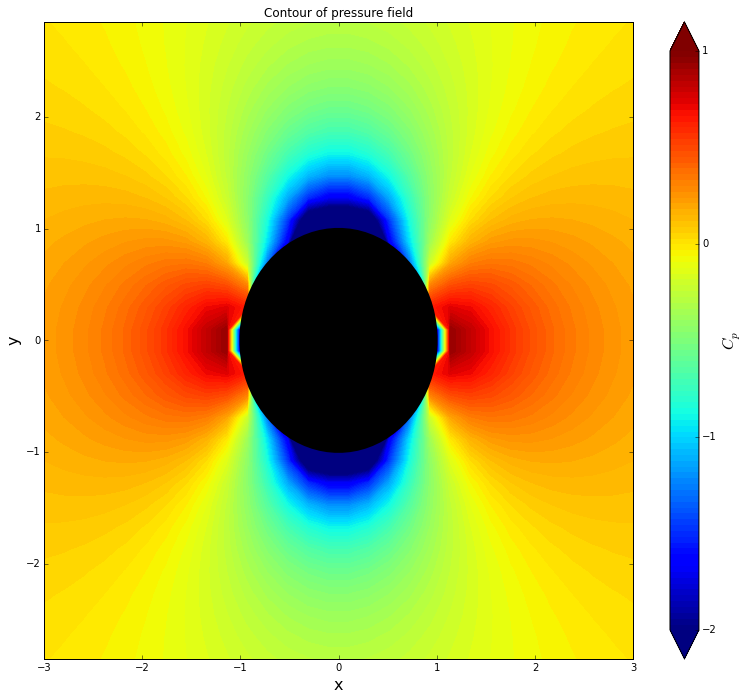

In [41]:
# computes the pressure field
cp = 1.0 - (u**2+v**2)/freestream.u_inf**2

# plots the pressure field
size=12
plt.figure(figsize=(1.1*size, (y_end-y_start)/(x_end-x_start)*size))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
contf = plt.contourf(X, Y, cp, levels=np.linspace(-2.0, 1.0, 100), extend='both')
cbar = plt.colorbar(contf)
cbar.set_label('$C_p$', fontsize=16)
cbar.set_ticks([-2.0, -1.0, 0.0, 1.0])
plt.fill([panel.xc for panel in panels], 
         [panel.yc for panel in panels], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.title('Contour of pressure field');